In [ ]:
# %pip install tensorflow-addons

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random
import tensorflow as tf
import tensorflow_addons as tfa


Segmentation Models: using `keras` framework.


C:\Users\bsvsk\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\bsvsk\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

In [2]:
train_img_dir = "data/data_for_keras_aug/train_images/train/"
train_mask_dir = "data/data_for_keras_aug/train_masks/train/"

In [3]:
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

In [4]:
num_images = len(os.listdir(train_img_dir))

In [5]:
img_num = random.randint(0, num_images-1)

In [6]:
img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

In [7]:
mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

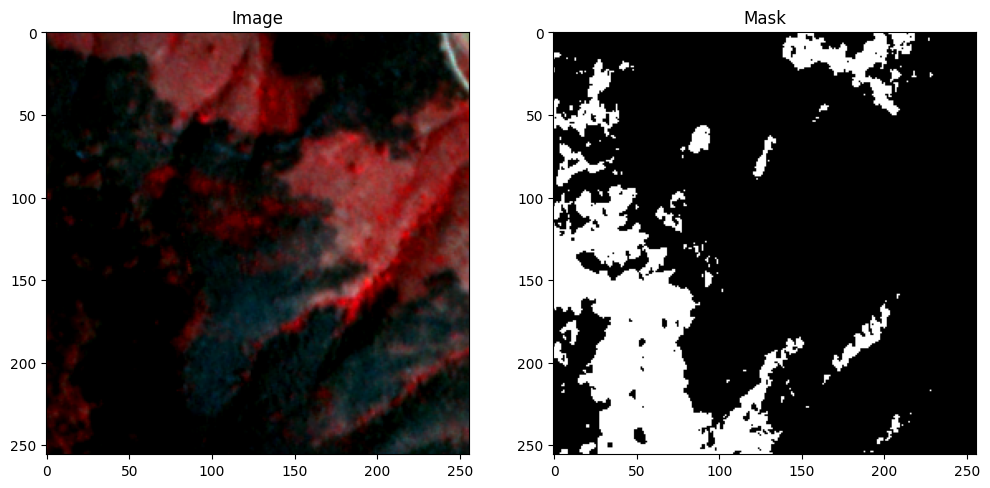

In [8]:
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


Defining seed size

In [9]:
seed=24
batch_size= 8
n_classes=2

In [10]:
# %pip install -U scikit-learn

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

In [12]:
#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [13]:

def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = mask / 255.0  # Normalize mask values to [0, 1]
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [16]:
train_img_path = "data/data_for_keras_aug/train_images/"
train_mask_path = "data/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=2)

In [17]:
x, y = train_img_gen.__next__()

Found 70 images belonging to 1 classes.
Found 70 images belonging to 1 classes.


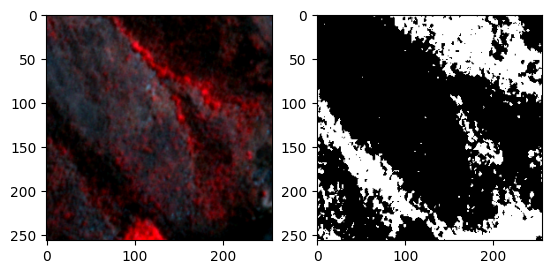

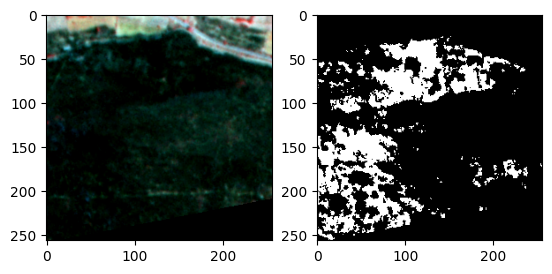

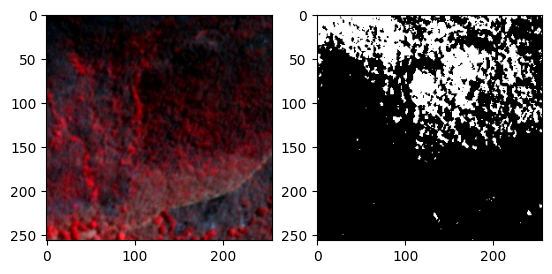

In [18]:
for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [19]:
val_img_path = "data/data_for_keras_aug/val_images/"
val_mask_path = "data/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=2)

In [20]:
x_val, y_val = val_img_gen.__next__()

Found 24 images belonging to 1 classes.
Found 24 images belonging to 1 classes.


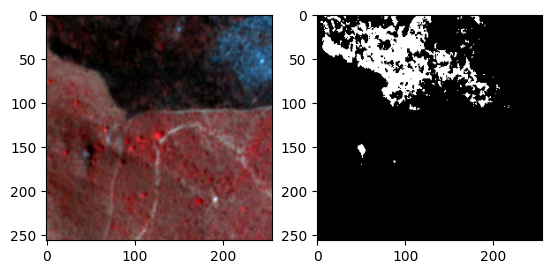

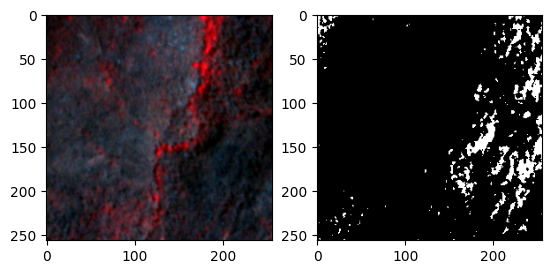

In [21]:
for i in range(0,2):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [22]:
num_train_imgs = len(os.listdir('data/data_for_keras_aug/train_images/train/'))
num_val_images = len(os.listdir('data/data_for_keras_aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

In [23]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]


In [24]:
IMG_CHANNELS

3

In [25]:
y.shape[3]

2

In [26]:
n_classes=2

In [27]:
from tensorflow.keras.optimizers.legacy import Adam
from segmentation_models.losses import DiceLoss
import tensorflow as tf

def sigmoid(y_true, y_pred):
    y_true_float = tf.cast(y_true, tf.float32)
    loss = tfa.losses.SigmoidFocalCrossEntropy()(y_true_float, y_pred)
    return loss

    
#     return loss
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.regularizers import l2
from segmentation_models.losses import DiceLoss

def custom_loss(y_true, y_pred):
    # Convert y_true to float32
    y_true_float = tf.cast(y_true, tf.float32)
    
    # Define the two loss components
    focal_loss = tfa.losses.SigmoidFocalCrossEntropy()(y_true_float, y_pred)
    dice_loss = DiceLoss()(y_true_float, y_pred)
    
    # Define the weights for each loss component
    focal_loss_weight = 0.6
    dice_loss_weight = 0.4
    
    # Calculate the combined loss with the weighted sum
    combined_loss = (focal_loss_weight * focal_loss) + (dice_loss_weight * dice_loss)
    
    # Add L2 regularization to the loss
    l2_reg = 1e-4  # You can experiment with different regularization strengths
    l2_loss = l2_reg * tf.reduce_sum([tf.reduce_mean(tf.square(w)) for w in model.trainable_weights])
    combined_loss += l2_loss
    
    return combined_loss




In [28]:
# import tensorflow as tf
# import tensorflow_addons as tfa

# # Define the Dice Loss function
# class DiceLoss(tf.keras.losses.Loss):
#     def __init__(self):
#         super(DiceLoss, self).__init__()

#     def call(self, y_true, y_pred):
#         intersection = tf.reduce_sum(y_true * y_pred)
#         union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#         dice = (2.0 * intersection + 1e-7) / (union + 1e-7)
#         return 1.0 - dice

# # Define the custom loss function
# def custom_loss(y_true, y_pred):
#     # Convert y_true to float32
#     y_true_float = tf.cast(y_true, tf.float32)
    
#     # Define the two loss components
#     focal_loss = tfa.losses.SigmoidFocalCrossEntropy()(y_true_float, y_pred)
#     dice_loss = DiceLoss()(y_true_float, y_pred)
    
#     # Define the weights for each loss component
#     focal_loss_weight = 0.6
#     dice_loss_weight = 0.4
    
#     # Calculate the combined loss with the weighted sum
#     combined_loss = (focal_loss_weight * focal_loss) + (dice_loss_weight * dice_loss)
    
#     # Add L2 regularization to the loss
#     l2_reg = 1e-4  # You can experiment with different regularization strengths
#     l2_loss = l2_reg * tf.reduce_sum([tf.reduce_mean(tf.square(w)) for w in tf.compat.v1.trainable_variables()])
#     combined_loss += l2_loss
    
#     return combined_loss




In [29]:
# import tensorflow as tf
# import tensorflow_addons as tfa
# from tensorflow.keras.losses import Loss, CategoricalCrossentropy

# # Define the Dice Loss function
# class DiceLoss(tf.keras.losses.Loss):
#     def __init__(self):
#         super(DiceLoss, self).__init__()

#     def call(self, y_true, y_pred):
#         intersection = tf.reduce_sum(y_true * y_pred)
#         union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#         dice = (2.0 * intersection + 1e-7) / (union + 1e-7)
#         return 1.0 - dice

# # Define the custom loss function
# def custom_loss(y_true, y_pred):
#     # Convert y_true to float32
#     y_true_float = tf.cast(y_true, tf.float32)
    
#     # Define the two loss components
#     focal_loss = tfa.losses.SigmoidFocalCrossEntropy()(y_true_float, y_pred)
#     dice_loss = DiceLoss()(y_true_float, y_pred)
    
#     # Define the weights for each loss component
#     focal_loss_weight = 0.6
#     dice_loss_weight = 0.4
    
#     # Calculate the combined loss with the weighted sum
#     combined_loss = (focal_loss_weight * focal_loss) + (dice_loss_weight * dice_loss)
    
#     # Add L2 regularization to the loss
#     l2_reg = 1e-4  # You can experiment with different regularization strengths
#     l2_loss = l2_reg * tf.reduce_sum([tf.reduce_mean(tf.square(w)) for w in tf.compat.v1.trainable_variables()])
#     combined_loss += l2_loss
    
#     categorical_loss = CategoricalCrossentropy()(y_true, y_pred)
#     combined_loss += categorical_loss
    
#     return combined_loss


In [34]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=2, activation='softmax')
# model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
#                 input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
#                 classes=1, activation='sigmoid')
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

# model.compile(optimizer=adam_optimizer, loss=custom_loss, metrics=['accuracy'])
model.compile(optimizer=adam_optimizer, loss=custom_loss, metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])
# model.compile(optimizer='Adam', loss=custom_loss, metrics=[sm.metrics.iou_score])

In [35]:
print(model.summary())
print(model.input_shape)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

 zero_padding2d_40 (ZeroPadding  (None, 66, 66, 64)  0           ['stage1_unit3_relu1[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage1_unit3_conv1 (Conv2D)    (None, 64, 64, 64)   36864       ['zero_padding2d_40[0][0]']      
                                                                                                  
 stage1_unit3_bn2 (BatchNormali  (None, 64, 64, 64)  256         ['stage1_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage1_unit3_relu2 (Activation  (None, 64, 64, 64)  0           ['stage1_unit3_bn2[0][0]']       
 )                                                                                                
          

 zation)                                                                                          
                                                                                                  
 stage2_unit3_relu2 (Activation  (None, 32, 32, 128)  0          ['stage2_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_47 (ZeroPadding  (None, 34, 34, 128)  0          ['stage2_unit3_relu2[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage2_unit3_conv2 (Conv2D)    (None, 32, 32, 128)  147456      ['zero_padding2d_47[0][0]']      
                                                                                                  
 add_21 (A

 2D)                                                                                              
                                                                                                  
 stage3_unit2_conv2 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_53[0][0]']      
                                                                                                  
 add_24 (Add)                   (None, 16, 16, 256)  0           ['stage3_unit2_conv2[0][0]',     
                                                                  'add_23[0][0]']                 
                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, 16, 16, 256)  1024       ['add_24[0][0]']                 
 zation)                                                                                          
                                                                                                  
 stage3_un

 zation)                                                                                          
                                                                                                  
 stage3_unit6_relu1 (Activation  (None, 16, 16, 256)  0          ['stage3_unit6_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_60 (ZeroPadding  (None, 18, 18, 256)  0          ['stage3_unit6_relu1[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage3_unit6_conv1 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_60[0][0]']      
                                                                                                  
 stage3_un

 2D)                                                                                              
                                                                                                  
 stage4_unit3_conv1 (Conv2D)    (None, 8, 8, 512)    2359296     ['zero_padding2d_66[0][0]']      
                                                                                                  
 stage4_unit3_bn2 (BatchNormali  (None, 8, 8, 512)   2048        ['stage4_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage4_unit3_relu2 (Activation  (None, 8, 8, 512)   0           ['stage4_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padd

 decoder_stage2b_conv (Conv2D)  (None, 64, 64, 64)   36864       ['decoder_stage2a_relu[0][0]']   
                                                                                                  
 decoder_stage2b_bn (BatchNorma  (None, 64, 64, 64)  256         ['decoder_stage2b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage2b_relu (Activati  (None, 64, 64, 64)  0           ['decoder_stage2b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 128, 128, 64  0          ['decoder_stage2b_relu[0][0]']   
 ampling2D)                     )                                                                 
          

In [30]:
history = model.fit(train_img_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=300,
                    verbose=1,
                    validation_data=val_img_gen,
                    validation_steps=val_steps_per_epoch)

# Check if the training was successful before saving the model
if history is not None:
    model.save('sigmoid_300.hdf5')


Epoch 1/300
8/8 [==============================] - 32s 1s/step - loss: 0.4625 - accuracy: 0.3609 - val_loss: 0.3810 - val_accuracy: 0.4545
Epoch 2/300
8/8 [==============================] - 3s 360ms/step - loss: 0.3193 - accuracy: 0.6298 - val_loss: 0.8699 - val_accuracy: 0.4937
Epoch 3/300
8/8 [==============================] - 3s 369ms/step - loss: 0.2610 - accuracy: 0.8186 - val_loss: 2.4989 - val_accuracy: 0.2618
Epoch 4/300
8/8 [==============================] - 3s 356ms/step - loss: 0.2205 - accuracy: 0.8651 - val_loss: 1.8412 - val_accuracy: 0.2360
Epoch 5/300
8/8 [==============================] - 3s 390ms/step - loss: 0.1915 - accuracy: 0.8839 - val_loss: 0.3750 - val_accuracy: 0.6580
Epoch 6/300
8/8 [==============================] - 3s 349ms/step - loss: 0.1832 - accuracy: 0.8821 - val_loss: 0.3153 - val_accuracy: 0.7383
Epoch 7/300
8/8 [==============================] - 3s 413ms/step - loss: 0.1789 - accuracy: 0.8942 - val_loss: 0.5178 - val_accuracy: 0.7534
Epoch 8/300
8/8

KeyboardInterrupt: 

In [36]:
# from keras.callbacks import ModelCheckpoint


# checkpoint = ModelCheckpoint('best_customDice_500.hdf5', 
#                              monitor='val_loss',  # Choose the metric to monitor
#                              save_best_only=True,  # Save only the best model
#                              mode='min',  # 'min' if monitoring loss, 'max' if monitoring accuracy
#                              verbose=1)


# history = model.fit(train_img_gen,
#                     steps_per_epoch=steps_per_epoch,
#                     epochs=500,
#                     verbose=1,
#                     validation_data=val_img_gen,
#                     validation_steps=val_steps_per_epoch,
#                     callbacks=[checkpoint])

# # The best model will be saved as 'best_sigmoid_model.hdf5'


#accuracy
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('Latest_500.hdf5',
                             monitor='val_accuracy', 
                             save_best_only=True,  
                             mode='max',  
                             verbose=1)


history = model.fit(train_img_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=500,
                    verbose=1,
                    validation_data=val_img_gen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[checkpoint])



Epoch 1/500
8/8 [==============================] - ETA: 0s - loss: 0.8075 - accuracy: 0.2344 - mean_io_u: 0.2505
Epoch 1: val_accuracy improved from -inf to 0.15412, saving model to Latest_500.hdf5
8/8 [==============================] - 14s 692ms/step - loss: 0.8075 - accuracy: 0.2344 - mean_io_u: 0.2505 - val_loss: 6.3218 - val_accuracy: 0.1541 - val_mean_io_u: 0.1909
Epoch 2/500
8/8 [==============================] - ETA: 0s - loss: 0.4364 - accuracy: 0.2776 - mean_io_u: 0.2521
Epoch 2: val_accuracy improved from 0.15412 to 0.21722, saving model to Latest_500.hdf5
8/8 [==============================] - 4s 468ms/step - loss: 0.4364 - accuracy: 0.2776 - mean_io_u: 0.2521 - val_loss: 7.2882 - val_accuracy: 0.2172 - val_mean_io_u: 0.1364
Epoch 3/500
8/8 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.5678 - mean_io_u: 0.2534
Epoch 3: val_accuracy did not improve from 0.21722
8/8 [==============================] - 3s 344ms/step - loss: 0.3386 - accuracy: 0.5678 - m

8/8 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.9259 - mean_io_u: 0.2523
Epoch 24: val_accuracy did not improve from 0.82038
8/8 [==============================] - 3s 359ms/step - loss: 0.1348 - accuracy: 0.9259 - mean_io_u: 0.2523 - val_loss: 0.2940 - val_accuracy: 0.8023 - val_mean_io_u: 0.2500
Epoch 25/500
8/8 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.9298 - mean_io_u: 0.2522
Epoch 25: val_accuracy improved from 0.82038 to 0.83631, saving model to Latest_500.hdf5
8/8 [==============================] - 4s 597ms/step - loss: 0.1279 - accuracy: 0.9298 - mean_io_u: 0.2522 - val_loss: 0.2865 - val_accuracy: 0.8363 - val_mean_io_u: 0.2500
Epoch 26/500
8/8 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.9266 - mean_io_u: 0.2522
Epoch 26: val_accuracy did not improve from 0.83631
8/8 [==============================] - 3s 351ms/step - loss: 0.1314 - accuracy: 0.9266 - mean_io_u: 0.2522 - val_loss: 0.2985 - val_

Epoch 48/500
8/8 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9499 - mean_io_u: 0.2519
Epoch 48: val_accuracy did not improve from 0.84677
8/8 [==============================] - 3s 359ms/step - loss: 0.0890 - accuracy: 0.9499 - mean_io_u: 0.2519 - val_loss: 0.6009 - val_accuracy: 0.8029 - val_mean_io_u: 0.2500
Epoch 49/500
8/8 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.9502 - mean_io_u: 0.2521
Epoch 49: val_accuracy did not improve from 0.84677
8/8 [==============================] - 3s 355ms/step - loss: 0.0863 - accuracy: 0.9502 - mean_io_u: 0.2521 - val_loss: 0.5723 - val_accuracy: 0.8202 - val_mean_io_u: 0.2500
Epoch 50/500
8/8 [==============================] - ETA: 0s - loss: 0.0912 - accuracy: 0.9471 - mean_io_u: 0.2518
Epoch 50: val_accuracy did not improve from 0.84677
8/8 [==============================] - 3s 348ms/step - loss: 0.0912 - accuracy: 0.9471 - mean_io_u: 0.2518 - val_loss: 0.6492 - val_accuracy: 0.7953 - val_m

8/8 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9574 - mean_io_u: 0.2513
Epoch 72: val_accuracy did not improve from 0.84677
8/8 [==============================] - 3s 353ms/step - loss: 0.0709 - accuracy: 0.9574 - mean_io_u: 0.2513 - val_loss: 0.7738 - val_accuracy: 0.8029 - val_mean_io_u: 0.2500
Epoch 73/500
8/8 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9609 - mean_io_u: 0.2513
Epoch 73: val_accuracy did not improve from 0.84677
8/8 [==============================] - 3s 350ms/step - loss: 0.0700 - accuracy: 0.9609 - mean_io_u: 0.2513 - val_loss: 0.8388 - val_accuracy: 0.7888 - val_mean_io_u: 0.2500
Epoch 74/500
8/8 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9540 - mean_io_u: 0.2516
Epoch 74: val_accuracy did not improve from 0.84677
8/8 [==============================] - 3s 346ms/step - loss: 0.0775 - accuracy: 0.9540 - mean_io_u: 0.2516 - val_loss: 0.7591 - val_accuracy: 0.8195 - val_mean_io_u: 0.2

8/8 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9620 - mean_io_u: 0.2511
Epoch 96: val_accuracy did not improve from 0.84677
8/8 [==============================] - 3s 349ms/step - loss: 0.0653 - accuracy: 0.9620 - mean_io_u: 0.2511 - val_loss: 0.8180 - val_accuracy: 0.8093 - val_mean_io_u: 0.2500
Epoch 97/500
8/8 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9623 - mean_io_u: 0.2512
Epoch 97: val_accuracy did not improve from 0.84677
8/8 [==============================] - 3s 355ms/step - loss: 0.0605 - accuracy: 0.9623 - mean_io_u: 0.2512 - val_loss: 0.6921 - val_accuracy: 0.8185 - val_mean_io_u: 0.2500
Epoch 98/500
8/8 [==============================] - ETA: 0s - loss: 0.0778 - accuracy: 0.9547 - mean_io_u: 0.2519
Epoch 98: val_accuracy did not improve from 0.84677
8/8 [==============================] - 3s 358ms/step - loss: 0.0778 - accuracy: 0.9547 - mean_io_u: 0.2519 - val_loss: 0.7672 - val_accuracy: 0.8119 - val_mean_io_u: 0.2

Epoch 120/500
8/8 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9609 - mean_io_u: 0.2514
Epoch 120: val_accuracy did not improve from 0.89236
8/8 [==============================] - 3s 385ms/step - loss: 0.0654 - accuracy: 0.9609 - mean_io_u: 0.2514 - val_loss: 0.2734 - val_accuracy: 0.8909 - val_mean_io_u: 0.2512
Epoch 121/500
8/8 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9587 - mean_io_u: 0.2510
Epoch 121: val_accuracy improved from 0.89236 to 0.90358, saving model to Latest_500.hdf5
8/8 [==============================] - 5s 640ms/step - loss: 0.0667 - accuracy: 0.9587 - mean_io_u: 0.2510 - val_loss: 0.2645 - val_accuracy: 0.9036 - val_mean_io_u: 0.2525
Epoch 122/500
8/8 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9636 - mean_io_u: 0.2514
Epoch 122: val_accuracy did not improve from 0.90358
8/8 [==============================] - 3s 361ms/step - loss: 0.0636 - accuracy: 0.9636 - mean_io_u: 0.2514 - val_

Epoch 144/500
8/8 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9561 - mean_io_u: 0.2500
Epoch 144: val_accuracy did not improve from 0.90358
8/8 [==============================] - 3s 351ms/step - loss: 0.0726 - accuracy: 0.9561 - mean_io_u: 0.2500 - val_loss: 0.3360 - val_accuracy: 0.8973 - val_mean_io_u: 0.2501
Epoch 145/500
8/8 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9601 - mean_io_u: 0.2500
Epoch 145: val_accuracy did not improve from 0.90358
8/8 [==============================] - 3s 345ms/step - loss: 0.0640 - accuracy: 0.9601 - mean_io_u: 0.2500 - val_loss: 0.4107 - val_accuracy: 0.8807 - val_mean_io_u: 0.2500
Epoch 146/500
8/8 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9565 - mean_io_u: 0.2500
Epoch 146: val_accuracy did not improve from 0.90358
8/8 [==============================] - 3s 347ms/step - loss: 0.0683 - accuracy: 0.9565 - mean_io_u: 0.2500 - val_loss: 0.3289 - val_accuracy: 0.8974 -

8/8 [==============================] - 3s 354ms/step - loss: 0.0617 - accuracy: 0.9645 - mean_io_u: 0.2507 - val_loss: 0.1273 - val_accuracy: 0.9455 - val_mean_io_u: 0.3020
Epoch 168/500
8/8 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9643 - mean_io_u: 0.2503
Epoch 168: val_accuracy did not improve from 0.94597
8/8 [==============================] - 3s 353ms/step - loss: 0.0582 - accuracy: 0.9643 - mean_io_u: 0.2503 - val_loss: 0.1478 - val_accuracy: 0.9350 - val_mean_io_u: 0.2902
Epoch 169/500
8/8 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9689 - mean_io_u: 0.2501
Epoch 169: val_accuracy did not improve from 0.94597
8/8 [==============================] - 3s 351ms/step - loss: 0.0514 - accuracy: 0.9689 - mean_io_u: 0.2501 - val_loss: 0.1007 - val_accuracy: 0.9384 - val_mean_io_u: 0.2814
Epoch 170/500
8/8 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9679 - mean_io_u: 0.2500
Epoch 170: val_accuracy did no

Epoch 191/500
8/8 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9618 - mean_io_u: 0.2502
Epoch 191: val_accuracy did not improve from 0.97029
8/8 [==============================] - 3s 352ms/step - loss: 0.0597 - accuracy: 0.9618 - mean_io_u: 0.2502 - val_loss: 0.0887 - val_accuracy: 0.9496 - val_mean_io_u: 0.2500
Epoch 192/500
8/8 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9672 - mean_io_u: 0.2502
Epoch 192: val_accuracy did not improve from 0.97029
8/8 [==============================] - 3s 359ms/step - loss: 0.0544 - accuracy: 0.9672 - mean_io_u: 0.2502 - val_loss: 0.0572 - val_accuracy: 0.9688 - val_mean_io_u: 0.2500
Epoch 193/500
8/8 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9606 - mean_io_u: 0.2501
Epoch 193: val_accuracy improved from 0.97029 to 0.97217, saving model to Latest_500.hdf5
8/8 [==============================] - 5s 665ms/step - loss: 0.0623 - accuracy: 0.9606 - mean_io_u: 0.2501 - val_

Epoch 215/500
8/8 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9701 - mean_io_u: 0.2501
Epoch 215: val_accuracy improved from 0.97230 to 0.97236, saving model to Latest_500.hdf5
8/8 [==============================] - 8s 1s/step - loss: 0.0483 - accuracy: 0.9701 - mean_io_u: 0.2501 - val_loss: 0.0483 - val_accuracy: 0.9724 - val_mean_io_u: 0.2500
Epoch 216/500
8/8 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9717 - mean_io_u: 0.2504
Epoch 216: val_accuracy did not improve from 0.97236
8/8 [==============================] - 3s 383ms/step - loss: 0.0481 - accuracy: 0.9717 - mean_io_u: 0.2504 - val_loss: 0.0514 - val_accuracy: 0.9709 - val_mean_io_u: 0.2500
Epoch 217/500
8/8 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9701 - mean_io_u: 0.2501
Epoch 217: val_accuracy did not improve from 0.97236
8/8 [==============================] - 3s 388ms/step - loss: 0.0526 - accuracy: 0.9701 - mean_io_u: 0.2501 - val_los

Epoch 239/500
8/8 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9699 - mean_io_u: 0.2500
Epoch 239: val_accuracy did not improve from 0.97404
8/8 [==============================] - 3s 366ms/step - loss: 0.0496 - accuracy: 0.9699 - mean_io_u: 0.2500 - val_loss: 0.0516 - val_accuracy: 0.9711 - val_mean_io_u: 0.2546
Epoch 240/500
8/8 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9690 - mean_io_u: 0.2500
Epoch 240: val_accuracy did not improve from 0.97404
8/8 [==============================] - 3s 356ms/step - loss: 0.0487 - accuracy: 0.9690 - mean_io_u: 0.2500 - val_loss: 0.0903 - val_accuracy: 0.9583 - val_mean_io_u: 0.2514
Epoch 241/500
8/8 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9690 - mean_io_u: 0.2504
Epoch 241: val_accuracy did not improve from 0.97404
8/8 [==============================] - 3s 351ms/step - loss: 0.0514 - accuracy: 0.9690 - mean_io_u: 0.2504 - val_loss: 0.0812 - val_accuracy: 0.9609 -

Epoch 263/500
8/8 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.9629 - mean_io_u: 0.2501
Epoch 263: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 353ms/step - loss: 0.0657 - accuracy: 0.9629 - mean_io_u: 0.2501 - val_loss: 0.5428 - val_accuracy: 0.8871 - val_mean_io_u: 0.2465
Epoch 264/500
8/8 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9622 - mean_io_u: 0.2500
Epoch 264: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 360ms/step - loss: 0.0611 - accuracy: 0.9622 - mean_io_u: 0.2500 - val_loss: 0.3671 - val_accuracy: 0.9133 - val_mean_io_u: 0.2456
Epoch 265/500
8/8 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9589 - mean_io_u: 0.2500
Epoch 265: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 367ms/step - loss: 0.0814 - accuracy: 0.9589 - mean_io_u: 0.2500 - val_loss: 0.2675 - val_accuracy: 0.8858 -

8/8 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9601 - mean_io_u: 0.2500
Epoch 287: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 358ms/step - loss: 0.0652 - accuracy: 0.9601 - mean_io_u: 0.2500 - val_loss: 0.0640 - val_accuracy: 0.9639 - val_mean_io_u: 0.2500
Epoch 288/500
8/8 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9642 - mean_io_u: 0.2500
Epoch 288: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 353ms/step - loss: 0.0575 - accuracy: 0.9642 - mean_io_u: 0.2500 - val_loss: 0.0623 - val_accuracy: 0.9666 - val_mean_io_u: 0.2500
Epoch 289/500
8/8 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9625 - mean_io_u: 0.2500
Epoch 289: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 356ms/step - loss: 0.0600 - accuracy: 0.9625 - mean_io_u: 0.2500 - val_loss: 0.1379 - val_accuracy: 0.9327 - val_mean_io_u

8/8 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9696 - mean_io_u: 0.2500
Epoch 311: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 348ms/step - loss: 0.0496 - accuracy: 0.9696 - mean_io_u: 0.2500 - val_loss: 0.0434 - val_accuracy: 0.9747 - val_mean_io_u: 0.2500
Epoch 312/500
8/8 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9705 - mean_io_u: 0.2500
Epoch 312: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 342ms/step - loss: 0.0487 - accuracy: 0.9705 - mean_io_u: 0.2500 - val_loss: 0.0519 - val_accuracy: 0.9698 - val_mean_io_u: 0.2500
Epoch 313/500
8/8 [==============================] - ETA: 0s - loss: 0.0479 - accuracy: 0.9693 - mean_io_u: 0.2500
Epoch 313: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 349ms/step - loss: 0.0479 - accuracy: 0.9693 - mean_io_u: 0.2500 - val_loss: 0.0469 - val_accuracy: 0.9725 - val_mean_io_u

8/8 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9727 - mean_io_u: 0.2500
Epoch 335: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 346ms/step - loss: 0.0460 - accuracy: 0.9727 - mean_io_u: 0.2500 - val_loss: 0.0783 - val_accuracy: 0.9606 - val_mean_io_u: 0.2500
Epoch 336/500
8/8 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9670 - mean_io_u: 0.2500
Epoch 336: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 356ms/step - loss: 0.0539 - accuracy: 0.9670 - mean_io_u: 0.2500 - val_loss: 0.0490 - val_accuracy: 0.9710 - val_mean_io_u: 0.2502
Epoch 337/500
8/8 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9676 - mean_io_u: 0.2500
Epoch 337: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 358ms/step - loss: 0.0522 - accuracy: 0.9676 - mean_io_u: 0.2500 - val_loss: 0.0795 - val_accuracy: 0.9500 - val_mean_io_u

8/8 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9706 - mean_io_u: 0.2500
Epoch 359: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 344ms/step - loss: 0.0509 - accuracy: 0.9706 - mean_io_u: 0.2500 - val_loss: 0.0567 - val_accuracy: 0.9677 - val_mean_io_u: 0.2500
Epoch 360/500
8/8 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9706 - mean_io_u: 0.2500
Epoch 360: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 351ms/step - loss: 0.0456 - accuracy: 0.9706 - mean_io_u: 0.2500 - val_loss: 0.0781 - val_accuracy: 0.9574 - val_mean_io_u: 0.2500
Epoch 361/500
8/8 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9687 - mean_io_u: 0.2500
Epoch 361: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 351ms/step - loss: 0.0516 - accuracy: 0.9687 - mean_io_u: 0.2500 - val_loss: 0.1092 - val_accuracy: 0.9463 - val_mean_io_u

8/8 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9726 - mean_io_u: 0.2500
Epoch 383: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 346ms/step - loss: 0.0414 - accuracy: 0.9726 - mean_io_u: 0.2500 - val_loss: 0.0401 - val_accuracy: 0.9766 - val_mean_io_u: 0.2500
Epoch 384/500
8/8 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9714 - mean_io_u: 0.2501
Epoch 384: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 351ms/step - loss: 0.0493 - accuracy: 0.9714 - mean_io_u: 0.2501 - val_loss: 0.0523 - val_accuracy: 0.9706 - val_mean_io_u: 0.2500
Epoch 385/500
8/8 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9734 - mean_io_u: 0.2511
Epoch 385: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 354ms/step - loss: 0.0433 - accuracy: 0.9734 - mean_io_u: 0.2511 - val_loss: 0.0498 - val_accuracy: 0.9684 - val_mean_io_u

8/8 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9699 - mean_io_u: 0.2503
Epoch 407: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 349ms/step - loss: 0.0519 - accuracy: 0.9699 - mean_io_u: 0.2503 - val_loss: 0.0546 - val_accuracy: 0.9695 - val_mean_io_u: 0.2512
Epoch 408/500
8/8 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9738 - mean_io_u: 0.2504
Epoch 408: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 356ms/step - loss: 0.0432 - accuracy: 0.9738 - mean_io_u: 0.2504 - val_loss: 0.0920 - val_accuracy: 0.9514 - val_mean_io_u: 0.2507
Epoch 409/500
8/8 [==============================] - ETA: 0s - loss: 0.0417 - accuracy: 0.9752 - mean_io_u: 0.2504
Epoch 409: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 353ms/step - loss: 0.0417 - accuracy: 0.9752 - mean_io_u: 0.2504 - val_loss: 0.0749 - val_accuracy: 0.9593 - val_mean_io_u

8/8 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9747 - mean_io_u: 0.2502
Epoch 431: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 349ms/step - loss: 0.0416 - accuracy: 0.9747 - mean_io_u: 0.2502 - val_loss: 0.0621 - val_accuracy: 0.9652 - val_mean_io_u: 0.2529
Epoch 432/500
8/8 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9733 - mean_io_u: 0.2502
Epoch 432: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 349ms/step - loss: 0.0440 - accuracy: 0.9733 - mean_io_u: 0.2502 - val_loss: 0.0591 - val_accuracy: 0.9688 - val_mean_io_u: 0.2534
Epoch 433/500
8/8 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9741 - mean_io_u: 0.2501
Epoch 433: val_accuracy did not improve from 0.97774
8/8 [==============================] - 3s 346ms/step - loss: 0.0428 - accuracy: 0.9741 - mean_io_u: 0.2501 - val_loss: 0.0723 - val_accuracy: 0.9647 - val_mean_io_u

Epoch 455/500
8/8 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9751 - mean_io_u: 0.2509
Epoch 455: val_accuracy did not improve from 0.97779
8/8 [==============================] - 3s 351ms/step - loss: 0.0414 - accuracy: 0.9751 - mean_io_u: 0.2509 - val_loss: 0.0633 - val_accuracy: 0.9626 - val_mean_io_u: 0.2526
Epoch 456/500
8/8 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9741 - mean_io_u: 0.2504
Epoch 456: val_accuracy did not improve from 0.97779
8/8 [==============================] - 3s 353ms/step - loss: 0.0412 - accuracy: 0.9741 - mean_io_u: 0.2504 - val_loss: 0.0605 - val_accuracy: 0.9664 - val_mean_io_u: 0.2518
Epoch 457/500
8/8 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9766 - mean_io_u: 0.2506
Epoch 457: val_accuracy did not improve from 0.97779
8/8 [==============================] - 3s 351ms/step - loss: 0.0396 - accuracy: 0.9766 - mean_io_u: 0.2506 - val_loss: 0.0616 - val_accuracy: 0.9663 -

8/8 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9788 - mean_io_u: 0.2504
Epoch 479: val_accuracy improved from 0.97779 to 0.97800, saving model to Latest_500.hdf5
8/8 [==============================] - 4s 582ms/step - loss: 0.0362 - accuracy: 0.9788 - mean_io_u: 0.2504 - val_loss: 0.0473 - val_accuracy: 0.9780 - val_mean_io_u: 0.2504
Epoch 480/500
8/8 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9770 - mean_io_u: 0.2503
Epoch 480: val_accuracy did not improve from 0.97800
8/8 [==============================] - 3s 361ms/step - loss: 0.0391 - accuracy: 0.9770 - mean_io_u: 0.2503 - val_loss: 0.0619 - val_accuracy: 0.9654 - val_mean_io_u: 0.2501
Epoch 481/500
8/8 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9718 - mean_io_u: 0.2506
Epoch 481: val_accuracy did not improve from 0.97800
8/8 [==============================] - 3s 362ms/step - loss: 0.0450 - accuracy: 0.9718 - mean_io_u: 0.2506 - val_loss: 0.0582 -

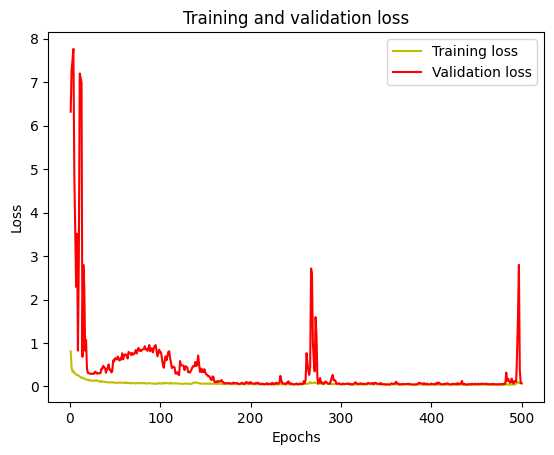

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

KeyError: 'iou_score'

### Accuracy

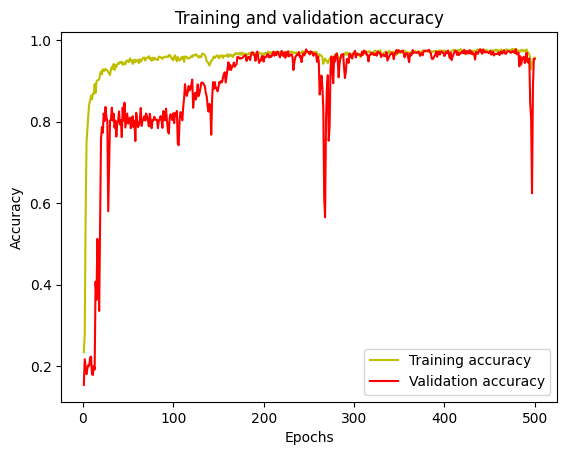

In [38]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


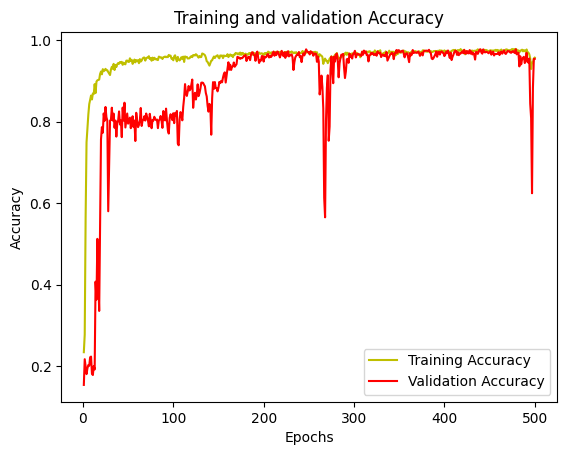

In [39]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [40]:
from keras.models import load_model


model = load_model("Latest_500.hdf5", compile=False)

#batch_size=8 #Checking IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 1s 1s/step
Mean IoU = 0.91756


### Accuracy

In [41]:
from keras.models import load_model

model = load_model("Latest_500.hdf5", compile=False)

# Test generator using validation data.
test_image_batch, test_mask_batch = val_img_gen.__next__()

# Convert categorical to integer for visualization and accuracy calculation

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

# Calculate accuracy
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(test_mask_batch_argmax, test_pred_batch_argmax)
print("Accuracy =", accuracy.result().numpy())


1/1 [==============================] - 1s 1s/step
Accuracy = 0.963583


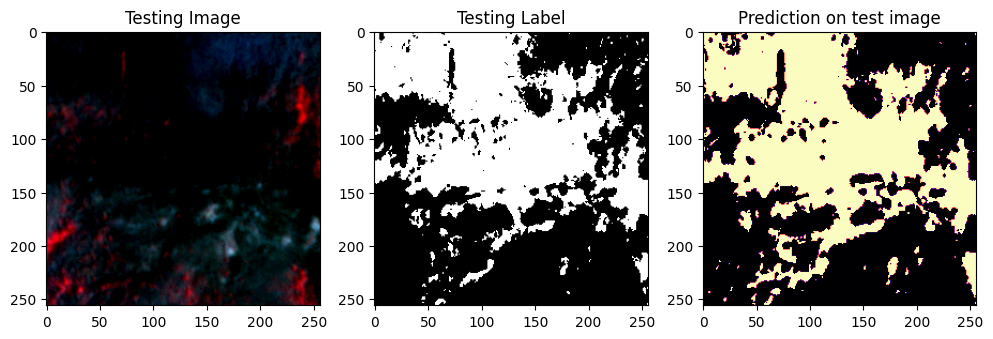

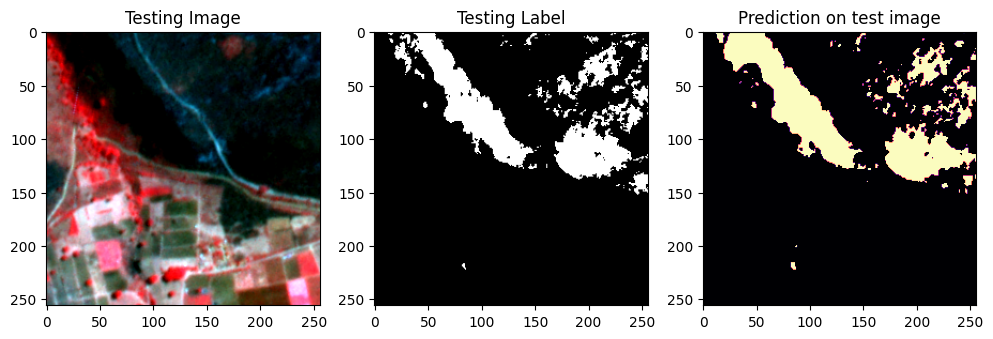

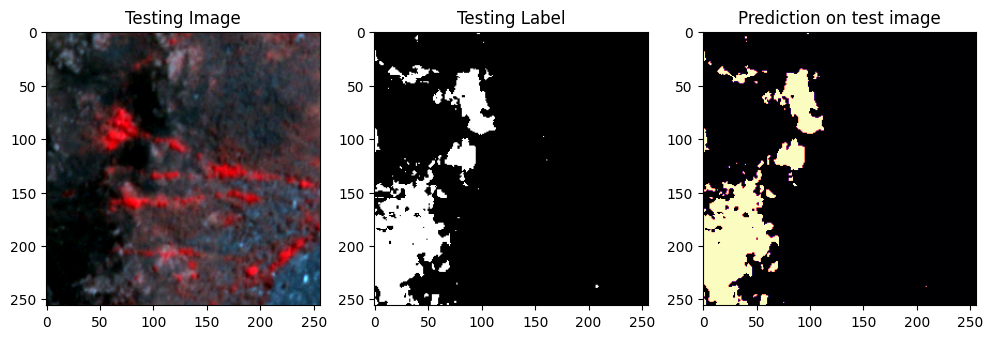

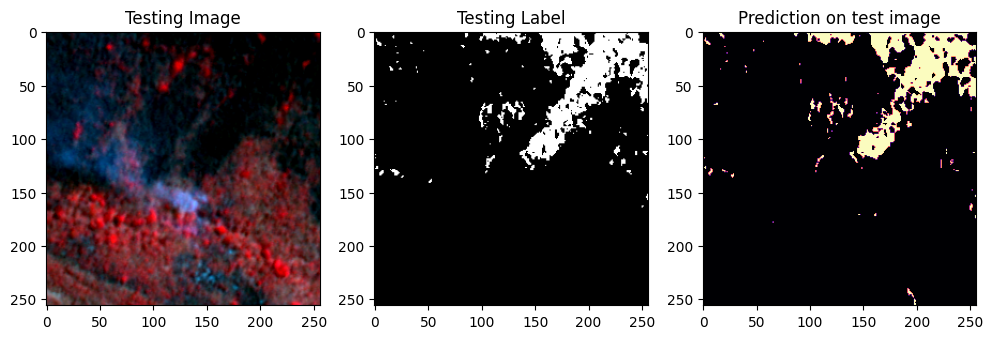

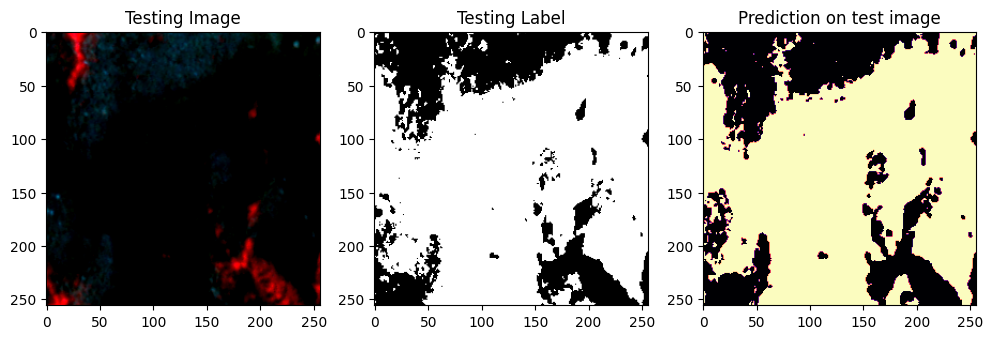

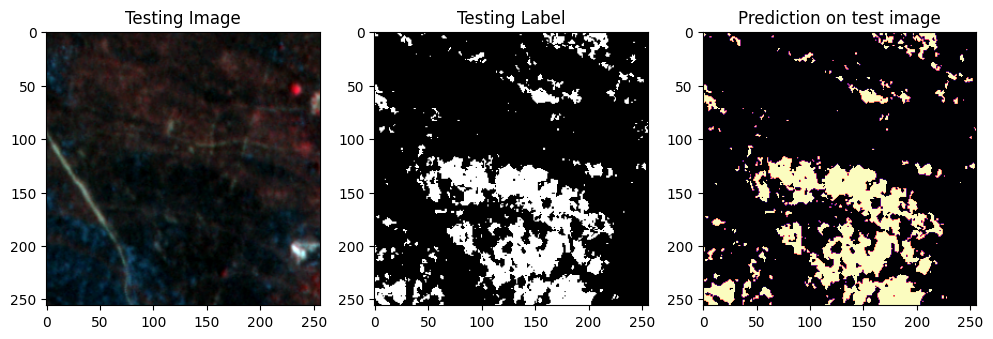

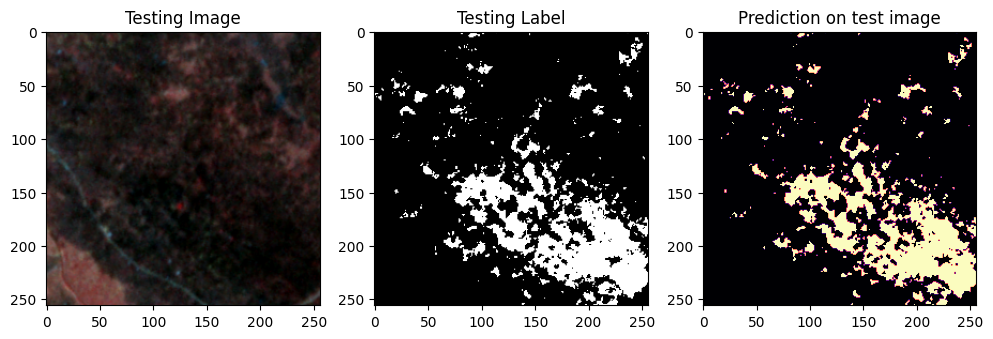

In [42]:
for x in range(0, test_image_batch.shape[0]-1):
    img_num=x
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_image_batch[img_num])
    plt.subplot(232)
    plt.title('Testing Label')

    plt.imshow(test_mask_batch_argmax[img_num],cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_pred_batch_argmax[img_num],cmap='magma')
    plt.show()


In [42]:
# from keras.models import load_model

# model = load_model("best_customDice_300.hdf5", compile=False)

# train_image_batch, train_mask_batch = train_img_gen.__next__()

# train_mask_batch_argmax = np.argmax(train_mask_batch, axis=3)
# train_pred_batch = model.predict(train_image_batch)
# train_pred_batch_argmax = np.argmax(train_pred_batch, axis=3)


# import tensorflow as tf

# accuracy = tf.keras.metrics.Accuracy()
# accuracy.update_state(train_mask_batch_argmax, train_pred_batch_argmax)
# print("Accuracy on Train Data =", accuracy.result().numpy())


1/1 [==============================] - 1s 769ms/step
Accuracy on Train Data = 0.8325176


In [43]:
for x in range(0, train_image_batch.shape[0]-1):
    img_num=x
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(train_image_batch[img_num])
    plt.subplot(232)
    plt.title('Testing Label')

    plt.imshow(train_mask_batch_argmax[img_num],cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(train_pred_batch_argmax[img_num],cmap='magma')
    plt.show()


NameError: name 'train_image_batch' is not defined